# Conjunto base

Para el entrenamiento de reconocimiento de rostro se usará como base el conjunto de datos [YALE FACE DATABASE](http://vision.ucsd.edu/content/yale-face-database) donde se tiene el rostro de  15 personas con 11 fotos por persona,una por cada expresión o configuración facial diferente: 
1. luz central
2. Con lentes
3. Feliz
4. Luz izquierda
5. Sin lentes
6. Normal
7. Luz derecha
8. Triste
9. Somnoliento
10. Sorprendido
11. Guiño

El objetivo es combinar por pares de fotografias 


In [4]:
# Librerias en uso


import os
import math   
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd

import cv2     # Para capturar videos
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

import tensorflow as tf


import dlib # Extraer rostro
from google.colab.patches import cv2_imshow
import joblib

In [2]:

# Establecer conecxión con drive para extraer los datos
from google.colab import drive #Conexión con Drive
drive.mount('/content/drive')
#Ubicación de los datos 
PATH = '/content/drive/MyDrive/Hackaton zinobe/Dataset/yalefaces/'

# lista de archivos de video
dir_list = os.listdir(PATH)

Mounted at /content/drive


In [ ]:
# Omitimos datos no necesarios o duplicados en el conjunto base
dir_list=[i for i in dir_list if i not in ['subject01.gif','Readme.txt','Readme.txt','subject01.glasses.gif'] ];dir_list

#parejas de fotos
Creamos todas las posibles parejas entre las imagenes sin repetición ni importancia en el orden para crear el conjunto de datos requerido; también se crea el label que será 1 si la pareja de imagenes corresponde a la misma persona o 0 si corresponden a personas diferentes.



In [5]:
dic  =  {1:'glasses', 2:'noglasses', 3:'happy', 4:'leftlight', 5:'normal', 6:'rightlight', 7:'sad', 8:'surprised', 9:'sleepy',10:'wink',11:'centerlight'}
dic_inver= {v: k for k, v in dic.items()}

In [6]:
persona = []
foto=[]
pat = []
id=[]
for f in dir_list:
  part1 = f.split('subject')[1].split('.')[0]
  part2 = f.split('subject')[1].split('.')[1]
  persona.append(part1)
  foto.append(dic_inver.get(part2))
  id.append(str(part1)+str(dic_inver.get(part2)))
  pat.append(PATH + f)

In [7]:
data_caras=pd.DataFrame(list(zip(id,persona,foto,pat)),columns=['id','persona','foto','pat'])
data_caras['join']=1
data_caras.head()

,id,persona,foto,pat,join
0,011,01,1,/content/drive/MyDrive/Hackaton zinobe/Dataset...,1
1,013,01,3,/content/drive/MyDrive/Hackaton zinobe/Dataset...,1
2,012,01,2,/content/drive/MyDrive/Hackaton zinobe/Dataset...,1
3,014,01,4,/content/drive/MyDrive/Hackaton zinobe/Dataset...,1
4,015,01,5,/content/drive/MyDrive/Hackaton zinobe/Dataset...,1


In [8]:
#Creamos la lista de todas las parejas posibles entre los datos sin repetición ni importar el orden
combi = [[a, b] for idx, a in enumerate(id) for b in id[idx + 1:]]

In [9]:
combi[0][0][:2]

'01'

In [10]:
labels=[]
for i in combi:
  if i[0][:2]==i[1][:2]:
    labels.append(1)
  else:
    labels.append(0)

In [11]:
data_labels=pd.DataFrame(list(zip(combi,labels)),columns=['combi','labels']);data_labels

,combi,labels
0,"[011, 013]",1
1,"[011, 012]",1
2,"[011, 014]",1
3,"[011, 015]",1
4,"[011, 016]",1
...,...,...
13361,"[159, 1510]",1
13362,"[159, 047]",0
13363,"[158, 1510]",1
13364,"[158, 047]",0


#Crear el conjunto de datos

Esta tarea se dicide en dos partes:
1. preprocesar las imagenes obteniendo de ellas solo el rostro y convertirlas en tensor.
2. construir las parejas definidas anteriormente de imagenes en un solo tensor, es decor, el tensor resultante tendrá 2 canales, en cada canal un rostro.



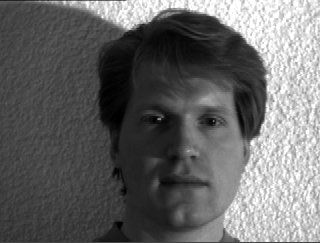

In [12]:
#cap = cv2.VideoCapture(data_caras['pat'][1])
cap = cv2.VideoCapture(data_caras['pat'][data_caras.id=='016'].item())
f, im = cap.read()
im.shape
#im=img
#im = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE) # en caso de estar rotada la imagen
cv2_imshow(im)

In [13]:
# Iniciar el dlib's face detector
detector = dlib.get_frontal_face_detector()
#Detectar la ubicación del rostro
faces = detector(im)
print(faces)

rectangles[[(120, 93) (245, 217)]]


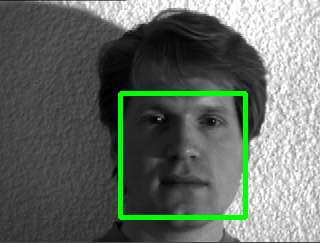

In [14]:
for face in faces:
  x1=face.left()
  y1=face.top()
  x2=face.right()
  y2=face.bottom()
# Dibujar un rectangulo sobre el rostro
  cv2.rectangle(im, (x1,y1), (x2,y2),(0,255,0),3)
cv2_imshow(im)

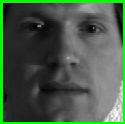

In [15]:
im = im[y1:y2, x1:x2]
cv2_imshow(im)

In [16]:
def cortar_cara(faces):
  for face in faces:
    x1=face.left()
    y1=face.top()
    x2=face.right()
    y2=face.bottom()
    im = im[y1:y2, x1:x2]


In [17]:
def scala_recorte_y_gris_gif(video_original,scala=(256,144),tamano=(48,48)):
  '''
  scala y tamaño de frame respuesta
  '''

  cap = cv2.VideoCapture(video_original)
  r=[]
  
  while True:
    ret, frame = cap.read()
    if ret == True:  #mientras se reciba un frame del video
        b = cv2.resize(frame,scala,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)#se redimensiona cada frame
        b= cv2.cvtColor(b, cv2.COLOR_BGR2GRAY) #cada frame de rgb a grices
        im= b
        detector = dlib.get_frontal_face_detector() #detector de rostro
        faces = detector(im)
        
        for face in faces:
          x1=face.left()
          y1=face.top()
          x2=face.right()
          y2=face.bottom()

        sub_face = im[y1:y2, x1:x2]
        
        
        sub_face= cv2.resize(sub_face,tamano,fx=0,fy=0, interpolation = cv2.INTER_CUBIC) # tamaño cuadrado de la imagen solo con el rostro
        im=sub_face
        im=tf.convert_to_tensor(im)
        im=tf.reshape(im,(1,)+tamano)
        array=im
              
        #out.write(im)
    else:
      break
  cap.release()
  #out.release()
  cv2.destroyAllWindows() #cierra el proceso con el video
  return array

In [18]:
rostro=scala_recorte_y_gris_gif(data_caras['pat'][1])

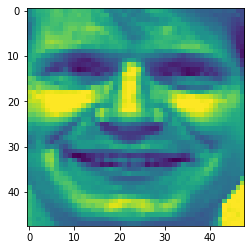

In [19]:
plt.imshow(rostro[0])

In [20]:
# Ejemplo de construir una pareja de datos
rostro2=scala_recorte_y_gris_gif(data_caras['pat'][40])
array=tf.concat([rostro,rostro2],0)

<Figure size 432x288 with 0 Axes>

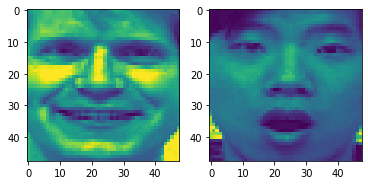

In [21]:
plt.figure()

f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(array[0])
axarr[1].imshow(array[1])

In [22]:
rostro1=scala_recorte_y_gris_gif(data_caras['pat'][data_caras.id=='011'].item())

In [ ]:
#construcción de las parejas para conjunto de datos
datos_preprocesados=[]
no_compatibles=[]
for i,j in data_labels['combi']:
  try:
    print(i,j)
    rostro1=scala_recorte_y_gris_gif(data_caras['pat'][data_caras.id==i].item())
    rostro2=scala_recorte_y_gris_gif(data_caras['pat'][data_caras.id==j].item())
    array=tf.concat([rostro1,rostro2],0)
    if i[:2]==j[:2]:
      label=1
    else:
      label=0
    dato=array,label
    datos_preprocesados.append(dato)
  except:
    no_compatibles.append([i,j])
    print('NO FUNCIONO: ',i,j)
  




#Guardar el conjunto de datos preprocesado y etiquetado

In [24]:
x,y=zip(*datos_preprocesados)

In [25]:
x = np.asarray(x)
y = np.asarray(y)
x.shape, y.shape

((12090, 2, 48, 48), (12090,))

In [28]:
PATH

'/content/drive/MyDrive/Hackaton zinobe/Dataset/yalefaces/'

In [29]:
import joblib

x_name = 'x.joblib'
y_name = 'y.joblib'
save_dir ='/content/drive/MyDrive/Hackaton zinobe/Dataset/'+'DATOS_PREPROCESADOS_ROSTRO'
savedx = joblib.dump(x, os.path.join(save_dir, x_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [5]:
X = joblib.load('/content/drive/MyDrive/Hackaton zinobe/Dataset/DATOS_PREPROCESADOS_ROSTRO/x.joblib')
y = joblib.load('/content/drive/MyDrive/Hackaton zinobe/Dataset/DATOS_PREPROCESADOS_ROSTRO/y.joblib')